<a href="https://colab.research.google.com/github/AnIsAsPe/Estimacion-probabilidad-conflicto-en-trayectorias-de-vuelos-paralelos/blob/main/Notebooks/MCMC_Estimaci%C3%B3n_probabilidad_de_conflicto_en_trayectorias_de_vuelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas y funciones

In [67]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
def covarianzas(r_a, sigma_c, r_c, v ):
  covA=np.zeros((20,20))
  covC=np.zeros((20,20))
  for s in range(20):
    covC[s,s] = (sigma_c**2)*(1-np.exp(-2*r_c*v*(s+1)/sigma_c))
    covA[s,s] = (r_a**2)*((s+1)**2)
    for t in range(s):
        covC[t,s] = covC[s,t]=(sigma_c**2)*(1-np.exp(-2*r_c*v*(t+1)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
        covA[t,s] = covA[s,t]=(r_a**2)*((t+1)**2)
  return covA, covC


# Generación de coordenadas along y cross

Como en el caso de Montecarlo iid, simulamos los errores en cada trayectoria utilizando el modelo de la distribución normal multinomial valiendonos de las covarianzas en el tiempo de la trayectoria (20 obs, 1 por min)

$x_{a,t} = vt + error_{a,t}~~~~$  (Along-track component)

$x_{c,t} = error_{c,t}~~~~~~~~~~~~~$       (Cross-track component)

$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$    

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$  


---
R. A. Paielli y H. Erzberger, «Conflict Probability Estimation for Free Flight», Journal of Guidance, Control, and Dynamics, may 2012, doi: 10.2514/2.4081.


In [69]:
sigma_c= 1
r_c=1/57
v=8
r_a = 0.25

covA, covC = covarianzas(r_a, sigma_c, r_c, v)

# Simulaciones con modelo AR (Construcción de la cadena de markov)

Cuando existe un distancia menor a lo establecido (radar) entonces se considera el siguiente modelo AR

$$Z_{i} = \phi(Z_{i-1}-2\mu) + \sqrt{1-\phi^{2}}(I_{i}-2\mu) +2\mu$$

donde:

- $\phi(Z_{i-1}-2\mu)$  es la parte de la trayectoria previa que conservamos, y
- $ \sqrt{1-\phi^{2}}(I_{i}-2\mu) $ es la parte de innovación que se añade



En caso contrario

$$Z_{i} = Z_{i-1} $$

In [ ]:
d = 8
n = 15000
𝜇 = np.zeros(20) + d/2   # vector de tamaño 20 que contiene la mitad de la distancia inicial de los aviones

# Simulamos nuestra primer vector de distancias entre dos aviones con
# trayectorias paralelas "startingpoint" (1 observación de la Cadena de Markov)

Z_a = np.random.multivariate_normal(np.zeros(20), 2*covA, size=1) + v*np.arange(1,21)
Z_c = np.random.multivariate_normal(2*𝜇, 2*covC, size=1)
Z = np.concatenate((Z_a, Z_c), axis=1)

# Generamos una vector auxiliar iid que nos ayudará a construir la cadena de Markov

I_a = np.random.multivariate_normal(np.zeros(20), 2*covA, size=n) + v*np.arange(1,21)
I_c = np.random.multivariate_normal(2*𝜇, 2*covC, size=n)
I = np.concatenate((I_a, I_c), axis=1)

In [ ]:
print(Z_a.shape, Z_c.shape, Z.shape)
print(I_a.shape, I_c.shape, I.shape)

(1, 20) (1, 20) (1, 40)
(500, 20) (500, 20) (500, 40)


$$Z_{i} = \phi(Z_{i-1}-2\mu) + \sqrt{1-\phi^{2}}(I_{i}-2\mu) +2\mu$$

In [ ]:
def simula_CadenaMarkov(d, startingPoint, dist_referencia = float("inf")):
        𝜇 = np.zeros(20) + d/2
        Z = startingPoint
        Z_a = Z[:,:20]
        Z_c = Z[:,20:]

        I_a = np.random.multivariate_normal(mean=np.zeros(20), cov=2*covA, size=n)
        I_c = np.random.multivariate_normal(mean=2*𝜇, cov=2*covC,size=n)
        I = np.concatenate((I_a, I_c), axis=1)

        for i in range(n-1):
            newZ_a = 𝜙*(Z_a[-1:,]) + 𝜙_bar*(I_a[i,:])
            newZ_c = 𝜙*(Z_c[-1:,] - 2*𝜇) + 𝜙_bar*(I_c[i,:] - 2*𝜇) + 2*𝜇

            # Se calcula la distancia minima de la nueva simulación(d_newZ).
            d_newZ = np.sqrt(np.min(newZ_a**2 + newZ_c**2))

            # Se considerará la nueva simulación cuando d_newZ sea menor o igual
            # a la distancia de referencia, en caso contrario nos quedaremos con
            # la trayectoria anterior.
            Z_a = np.append(Z_a,
                           newZ_a*(d_newZ <= dist_referencia) +                \
                           Z_a[-1]*(d_newZ > dist_referencia),
                           axis=0)
            Z_c = np.append(Z_c,
                            newZ_c*(d_newZ <= dist_referencia) +               \
                            Z_c[-1]*(d_newZ>dist_referencia),
                            axis=0)
        Z = np.concatenate((Z_a, Z_c), axis=1)
        return Z

# Encontrar distancias parciales convenientes

In [77]:
# Generamos un vector de distancias de tamaño n
n=1000
vector = np.random.normal(8, 1, n)
distancias = vector[vector < 8]

# Ordenamos el vector distancias de manera ascendente
distancias = np.sort(distancias)

# Elegimos el cuantil 2 de las distancias menores
cuantil = 0.02
inx = int(n * cuantil)
distancia_parcial = distancias[inx]

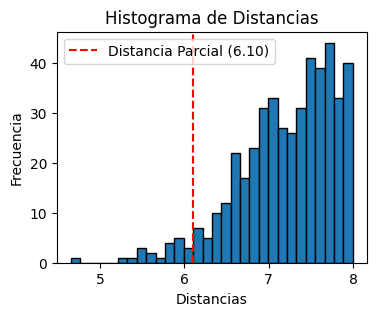

In [78]:
# Histograma
plt.figure(figsize=(4, 3))
plt.hist(distancias, bins=30, edgecolor='black')
plt.axvline(x=distancia_parcial, color='red', linestyle='--',
            label=f'Distancia Parcial ({distancia_parcial:.2f})')
plt.xlabel('Distancias')
plt.ylabel('Frecuencia')
plt.title('Histograma de Distancias')
plt.legend()

# Show the plot
plt.show()


In [ ]:
def identificar_rangos_distancia(n, d):
    cuantil = 0.98

    # 1. Simula la primera cadena de markov.
    𝜇 = np.zeros(20) + d/2
    Z_a = np.random.multivariate_normal(np.zeros(20), 2*covA, size=1) + v*np.arange(1,21)
    Z_c = np.random.multivariate_normal(2*𝜇, 2*covC, size=1)
    startingPoint = np.concatenate((Z_a, Z_c), axis=1)
    Z = simula_CadenaMarkov(d, startingPoint)

    # 2. Ordena las simulaciones de manera ascendente considerando la distancia
    # minima en cada simulación.
    Z = np.array(sorted(list(Z), key=lambda x:min(x[:20]**2 + x[20:]**2)))

    # 3. Conservamos el (1-cuantil)% de simulaciones en que se acercaron
    #    más los aviones identificamos la trayectoria que separa con el criterio descrito.
    renglon = int(np.ceil((1-cuantil)*n) - 1)

    # 4. Guardamos la distancia mínima del renglón vector identificado.
    distancias = np.array([])
    distancia_minima = np.sqrt(np.min((Z[renglon,:20]**2 + Z[renglon, 20:]**2)))
    distancias = np.append(distancias, distancia_minima)

    # Repetimos el proceso mientras la distancia encontrada sea mayor
    # que la distancia de conflicto.
    while (distancias[-1] > a):
        # 1. Comenzamos una nueva cadena de markov considerando el startingpoint
        #    la Z con la menor distancia ocurrida en la simulación anterior y la
        #    distancia de referencia identificada en la iteración anterior.
        startingPoint = (Z[0]).reshape(1,-1)
        Z = simula_CadenaMarkov(d, startingPoint, distancias[-1])

        # 2. Ordena las simulaciones en base a la distancia minima en cada simulación.
        Z = np.array(sorted(list(Z), key=lambda x: min(x[:20]**2+x[20:]**2)))

        # 3. Nos quedamos con el (1-cuantil)% de simulaciones en que se acercaron más los aviones.
        #    Identificamos la trayectoria que separa con el criterio descrito.
        renglon = int(np.ceil((1-cuantil)*n)-1)

        # 4. Guardamos la minima distancia minima del renglón vector identificado.
        distancia_minima = np.sqrt(np.min((Z[renglon,:20]**2+Z[renglon, 20:]**2)))
        distancias = np.append(distancias, distancia_minima)

    # 5. Nos aseguramos de que el primer nivel sea a.
    distancias = distancias[:-1]
    distancias = np.append(distancias, a)

    distancias=list(dict.fromkeys(distancias))

    return distancias

In [ ]:
a = 0.1
𝜙 = 0.9
𝜙_bar = np.sqrt(1-𝜙**2)
d = 10
n = 15000

rangos_distancias = identificar_rangos_distancia(n, d)
rangos_distancias

[6.540577477087834,
 5.0004945993145125,
 3.800369374709701,
 2.7480494189776574,
 1.7370478187682243,
 0.8886135113754713,
 0.2885173434156159,
 0.1]

# Encontrar la probabilidad de conflicto usando las distancias parciales

In [ ]:
def probaAR(n, d):

    # 0. DIVIDIMOS LA DISTANCIA d en DISTANCIAS PARCIALES
    rangos_distancias = identificar_rangos_distancia(n, d)

    # 1.CREAMOS EL PUNTO DE INICIO DE LA PRIMERA CADENA DE MARKOV
    𝜇 = np.zeros(20) + d/2
    Z_a = np.random.multivariate_normal(np.zeros(20), 2*covA, size=1) + v*np.arange(1,21)
    Z_c = np.random.multivariate_normal(2*𝜇, 2*covC, size=1)
    startingPoint = np.concatenate((Z_a, Z_c), axis=1)

    # 2. CONSTRUIMOS LA PRIMERA CADENA DE MARKOV
    Z = simula_CadenaMarkov(d, startingPoint)

    # 3. CALCULAMOS LA DISTANCIA MINIMA DE CADA SIMULACIÓN
    l = np.sqrt(np.amin(Z[:,:20]**2 + Z[:,20:]**2,axis=1))

    # 4. ESTIMAMOS LA PROBABILIDAD DE QUE SE LLEGUE A LA PRIMERA DISTANCIA PARCIAL
    P_vec = np.array(np.mean(l <= rangos_distancias[0]))  # se guarda en el vector P_vec


    for dist in range(1, len(rangos_distancias)):

        # 1. ELECCION DEL PUNTO DE PARTIDA DE LA NUEVA CADENA DE MARKOV
        d_parcial_ant = rangos_distancias[(dist-1)]
        if sum(l <= d_parcial_ant) > 0:
            # Si existe, se elige una trayectoria que haya llegado a la distancia de referencia anterior
            startingPoint = (Z[l <= d_parcial_ant][0]).reshape(1,-1)
        else:
            # Si no hay ninguna, se empieza con la que tenga la distancia más pequeña
            Z = np.array(sorted(list(Z),
                                key=lambda x:min(x[:20]**2 + x[20:]**2)))
            startingPoint = (Z[0]).reshape(1,-1)

        # 2. SIMULACION DE LA NUEVA CADENA DE MARKOV
        Z = simula_CadenaMarkov(d, startingPoint, d_parcial_ant)

        # 3. CALCULAMOS LA DISTANCIA MINIMA DE CADA SIMULACIÓN
        l = np.sqrt(np.amin(Z[:,:20]**2 + Z[:,20:]**2, axis=1))

        # 4. CALCULAMOS LA PROBABILIDAD DE ALCANZAR LA DISTANCIA PARCIAL
        P_vec = np.append(P_vec, np.mean(l <= rangos_distancias[dist]))

    # 5. CALCULAMOS LA PROBABILIDAD DE CONFLICTO COMO EL PRODUCTO DE LAS PROBABILIDADES CONDICIONALES.
    P = np.prod(P_vec)
    resultados= {'Distancias Parciales': rangos_distancias,
                 'Probabilidades Parciales':P_vec,
                 'Probabilidad de Conflicto':P}

    return resultados

In [ ]:
n = 15000
d = 8
probaAR(n,d)

{'Distancias Parciales': [4.521618765181297,
  3.0292270998440904,
  1.8448927360964005,
  0.9137649253189507,
  0.23159253720041512,
  0.1],
 'Probabilidades Parciales': array([0.01833333, 0.02653333, 0.02046667, 0.02026667, 0.01833333,
        0.11733333]),
 'Probabilidad de Conflicto': 4.3403577998573377e-10}

In [ ]:
d = 7
probaAR(n, d)

{'Distancias Parciales': [3.704800746472787,
  2.1156015103042156,
  0.9532938068079769,
  0.23054879429000652,
  0.1],
 'Probabilidades Parciales': array([0.01973333, 0.01793333, 0.0174    , 0.0254    , 0.1682    ]),
 'Probabilidad de Conflicto': 2.6306945757013327e-08}

In [ ]:
d = 6
probaAR(n, d)

{'Distancias Parciales': [2.703058954633923,
  1.145374935768793,
  0.2689092791907306,
  0.1],
 'Probabilidades Parciales': array([0.01846667, 0.01886667, 0.0202    , 0.10133333]),
 'Probabilidad de Conflicto': 7.131606708148147e-07}

In [ ]:
d = 5
probaAR(n, d)

{'Distancias Parciales': [1.8159546142379157, 0.472436080092972, 0.1],
 'Probabilidades Parciales': array([0.02126667, 0.01973333, 0.03586667]),
 'Probabilidad de Conflicto': 1.5051885037037035e-05}

In [ ]:
d = 4
probaAR(n, d)

{'Distancias Parciales': [0.922257509099814, 0.14165934205578615, 0.1],
 'Probabilidades Parciales': array([0.02086667, 0.0252    , 0.49786667]),
 'Probabilidad de Conflicto': 0.00026179820799999997}

In [ ]:
d = 4
probaAR(n,d)

{'Distancias Parciales': [0.9399536827571, 0.13674239154119097, 0.1],
 'Probabilidades Parciales': array([0.0204    , 0.02246667, 0.57193333]),
 'Probabilidad de Conflicto': 0.00026212848533333334}

In [ ]:
d = 4
probaAR(n,d)

{'Distancias Parciales': [0.895078212392745, 0.136458708774026, 0.1],
 'Probabilidades Parciales': array([0.02253333, 0.0194    , 0.53453333]),
 'Probabilidad de Conflicto': 0.00023366946488888887}